In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU
from tensorflow import keras

In [2]:
whole_file="https://raw.githubusercontent.com/lavibula/GoldPricePrediction/main/data/data_preparation/data_preparation.csv"
data =pd.read_csv(whole_file)
data


,Date,GOLD_open,GOLD_high,GOLD_low,GOLD_close,copper,crude_oil,DXY,EURUSD,MSCI,NASDAQ,NLR,platinum,RUT,silver,SP500,VIX
0,2023-11-03,1993.5,2011.9,1989.3,1999.2,3.6815,80.51,105.02,1.0732,497.76,13478.28,71.36,944.3,1760.71,23.285,4358.34,14.91
1,2023-11-02,1992.0,1999.2,1986.3,1993.5,3.6725,82.46,106.12,1.0622,487.02,13294.19,72.14,930.6,1714.21,22.846,4317.78,15.66
2,2023-11-01,1993.3,2005.9,1978.2,1987.5,3.6490,80.44,106.88,1.0570,471.85,13061.47,70.98,930.4,1669.70,22.790,4237.86,16.87
3,2023-10-31,2005.6,2017.7,1987.4,1994.3,3.6490,81.02,106.66,1.0578,471.55,12851.24,69.93,944.9,1662.28,22.952,4193.80,18.14
4,2023-10-30,2013.5,2016.8,1999.7,2005.6,3.6585,82.31,106.12,1.0617,481.99,12789.48,68.35,939.9,1647.29,23.396,4166.82,19.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3418,2010-04-08,1150.2,1154.7,1144.4,1152.9,3.5865,85.39,81.53,1.3361,36.19,2436.81,69.42,1717.1,699.64,18.127,1186.44,16.48
3419,2010-04-07,1135.2,1154.2,1133.3,1153.0,3.5975,85.88,81.44,1.3345,37.31,2431.16,69.75,1723.2,699.46,18.199,1182.45,16.62
3420,2010-04-06,1131.9,1139.6,1123.5,1136.0,3.6170,86.84,81.39,1.3400,37.37,2436.81,70.59,1704.5,701.48,17.931,1189.44,16.23
3421,2010-04-05,1122.0,1134.3,1120.8,1133.8,3.6315,86.62,81.09,1.3487,36.98,2429.53,70.44,1709.8,697.65,18.118,1187.44,17.02


In [3]:
data=data[::-1]
data = data.reset_index(drop=True)

time=data['Date']
data=data.drop(['Date'], axis=1)


In [4]:
data.head()

,GOLD_open,GOLD_high,GOLD_low,GOLD_close,copper,crude_oil,DXY,EURUSD,MSCI,NASDAQ,NLR,platinum,RUT,silver,SP500,VIX
0,1114.6,1129.1,1112.3,1126.1,3.5840,84.87,80.78,1.3590,36.47,2402.58,69.45,1675.6,683.98,17.890,1178.10,17.47
1,1122.0,1134.3,1120.8,1133.8,3.6315,86.62,81.09,1.3487,36.98,2429.53,70.44,1709.8,697.65,18.118,1187.44,17.02
2,1131.9,1139.6,1123.5,1136.0,3.6170,86.84,81.39,1.3400,37.37,2436.81,70.59,1704.5,701.48,17.931,1189.44,16.23
3,1135.2,1154.2,1133.3,1153.0,3.5975,85.88,81.44,1.3345,37.31,2431.16,69.75,1723.2,699.46,18.199,1182.45,16.62
4,1150.2,1154.7,1144.4,1152.9,3.5865,85.39,81.53,1.3361,36.19,2436.81,69.42,1717.1,699.64,18.127,1186.44,16.48


In [5]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [6]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

In [7]:
time_step=30
train_time_line=[]
val_time_line=[]
test_time_line=[]

In [8]:
def scale_sequence_data(df,timesteps ,close_col_idx):
    x = []
    y = []
    timeLine=[]
    for i in range(len(df)-timesteps):    
        scaler=MinMaxScaler()      
        scaler.fit(df[i:i+timesteps,:])
        timeLine.append((scaler.data_min_[close_col_idx],scaler.data_max_[close_col_idx]))
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=df[i+timesteps].reshape(1,-1)
        value=scaler.transform(value)
        y.append(value[:,close_col_idx])

    return np.array(x),np.array(y),timeLine


In [9]:
train_x, train_y,train_time_line = scale_sequence_data(train_np, time_step,data.columns.get_loc('GOLD_close'))
val_x,val_y,val_time_line =scale_sequence_data(val_np,time_step ,data.columns.get_loc('GOLD_close'))
test_x, test_y,test_time_line = scale_sequence_data(test_np, time_step,data.columns.get_loc('GOLD_close'))

In [10]:
model=Sequential()
model.add(GRU(units=64,return_sequences=True,recurrent_dropout=0.35))
model.add(GRU(units=32,return_sequences=False,recurrent_dropout=0.35))
model.add(Dense(units=16))
model.add(Dense(1))
moniter=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,  verbose=1,restore_best_weights=True)
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=1, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])
model.summary()




74/74 [==============================] - 13s 61ms/step - loss: 0.0847 - val_loss: 0.0519
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            15744     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 25697 (100.38 KB)
Trainable params: 25697 (100.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=100, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])

Epoch 1/100
74/74 [==============================] - 12s 63ms/step - loss: 0.0380 - val_loss: 0.0429
Epoch 2/100
74/74 [==============================] - 3s 46ms/step - loss: 0.0320 - val_loss: 0.0364
Epoch 3/100
74/74 [==============================] - 3s 46ms/step - loss: 0.0304 - val_loss: 0.0328
Epoch 4/100
74/74 [==============================] - 4s 50ms/step - loss: 0.0304 - val_loss: 0.0330
Epoch 5/100
74/74 [==============================] - 4s 50ms/step - loss: 0.0291 - val_loss: 0.0329
Epoch 6/100
74/74 [==============================] - 3s 44ms/step - loss: 0.0295 - val_loss: 0.0316
Epoch 7/100
74/74 [==============================] - 4s 49ms/step - loss: 0.0282 - val_loss: 0.0316
Epoch 8/100
74/74 [==============================] - 4s 52ms/step - loss: 0.0282 - val_loss: 0.0311
Epoch 9/100
74/74 [==============================] - 4s 50ms/step - loss: 0.0281 - val_loss: 0.0338
Epoch 10/100
74/74 [==============================] - 4s 50ms/step - loss: 0.0283 - val_loss: 0.034

In [12]:
model.evaluate(train_x,train_y)
model.evaluate(val_x,val_y)
model.evaluate(test_x,test_y)

16/16 [==============================] - 0s 14ms/step - loss: 0.0250


0.02501644752919674

In [13]:
predictions = model.predict(test_x)
test_y=test_y.reshape(-1,1)
prec_train=model.predict(train_x)
pre_val=model.predict(val_x)

16/16 [==============================] - 0s 25ms/step


In [21]:
model.save("gru.h5")

In [14]:
def inverseTransform(value, timeline):
    result = []
    for i in range(len(timeline)):
        min_val = timeline[i][0]
        max_val = timeline[i][1]
        original_value = (value[i] * (max_val - min_val)) + min_val
        result.append(original_value)
    return np.array(result)

In [15]:
test_after_inverse=inverseTransform(predictions,test_time_line)
true_after_inverse=inverseTransform(test_y,test_time_line)
inverse_train_pred=inverseTransform(prec_train,train_time_line)
inverse_train_true=inverseTransform(train_y,train_time_line)

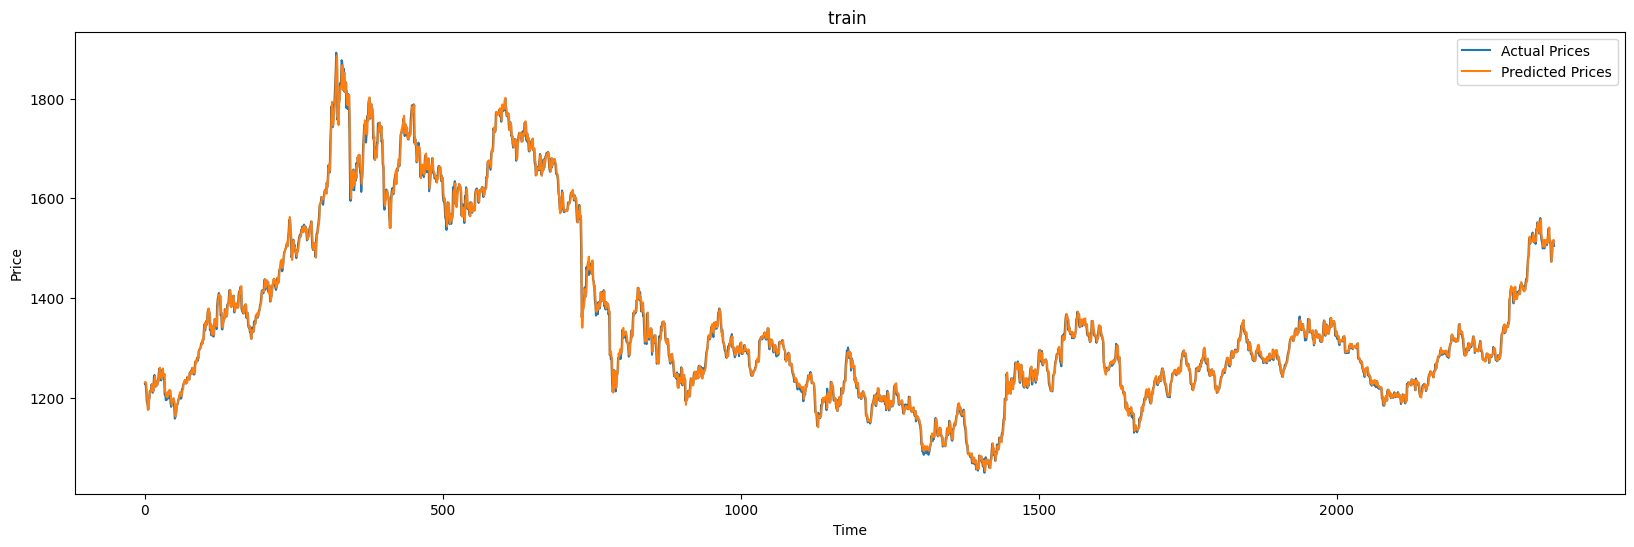

In [16]:
# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(inverse_train_true, label='Actual Prices')
plt.plot(inverse_train_pred, label='Predicted Prices')

plt.title('train ')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

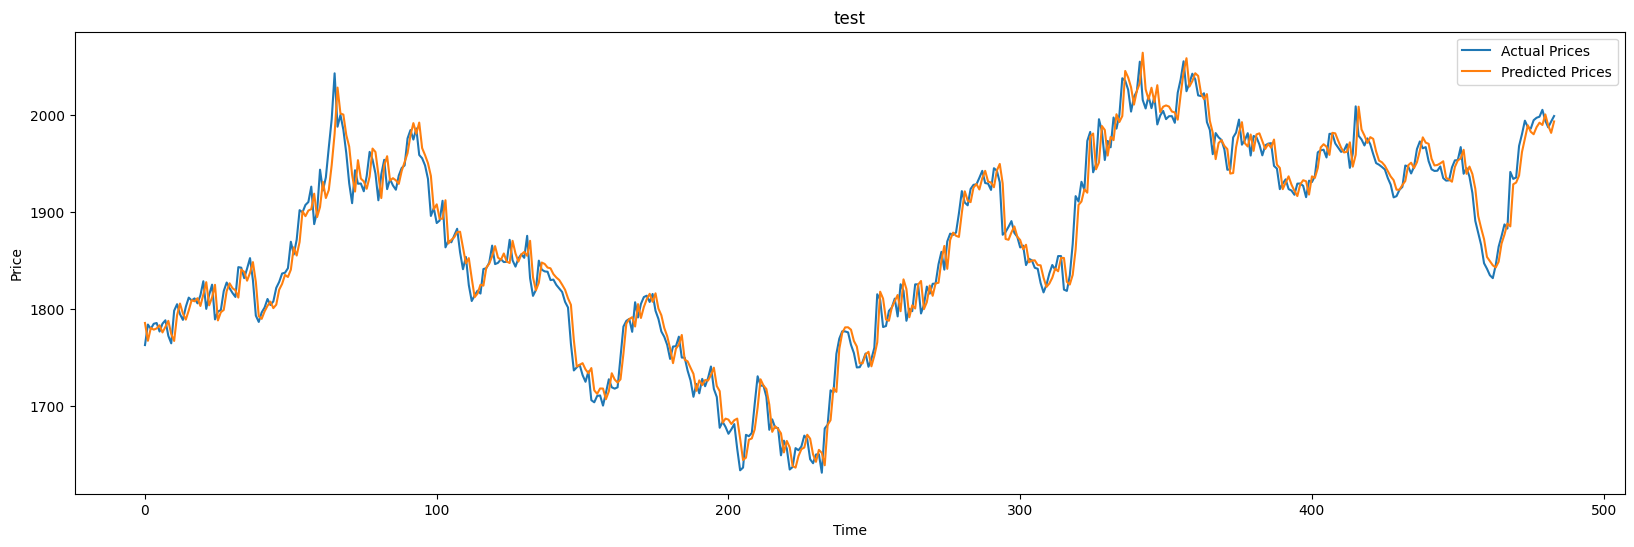

In [17]:
# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(true_after_inverse, label='Actual Prices')
plt.plot(test_after_inverse, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:

true_train=inverse_train_true
prediction_train=inverse_train_pred
prediction_test=test_after_inverse
true_test=true_after_inverse    
def print_evaluation_results(true_values, predicted_values, dataset_name):
    print("Test ACCuracy for", dataset_name)
    print("------------------------------------------------------")
    # RMSE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    print("Root Mean Square Error (RMSE): {:.4f}".format(rmse))
    
    # MAPE
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))


    #r2 score
    print("R2 score: ", r2_score(true_values,predicted_values))

# Print evaluation results for the train set
print_evaluation_results(true_train, prediction_train, "train set")

# Print evaluation results for the test set
print_evaluation_results(true_test, prediction_test, "test set")

Test ACCuracy for train set
------------------------------------------------------
Root Mean Square Error (RMSE): 13.9366
Mean Absolute Percentage Error (MAPE): 0.0069
R2 score:  0.9938876963737757
Test ACCuracy for test set
------------------------------------------------------
Root Mean Square Error (RMSE): 17.4278
Mean Absolute Percentage Error (MAPE): 0.0071
R2 score:  0.9706480588958025
